<a href="https://colab.research.google.com/github/michal-filipiak/IML-bearing-failure-forecast/blob/master/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Downloading and unpacking Dataset

In [ ]:
!wget -O data.7z https://ti.arc.nasa.gov/c/3/
!7z e data.7z
!unrar x -Y 1st_test.rar

--2022-01-20 21:19:06--  https://ti.arc.nasa.gov/c/3/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z [following]
--2022-01-20 21:19:07--  https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 1075320408 (1.0G)
Saving to: ‘data.7z’

data.7z             100%[===================>]   1.00G   955KB/s    in 11m 48s 

2022-01-20 21:30:55 (1.45 MB/s) - ‘data.7z’ saved [1075320408/1075320408]


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M 

In [ ]:
import glob
import datetime

import numpy as np
import pandas as pd
import scipy.stats as sts
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing

- Load dataset to pandas DataFrame
- Compute basic column-wise summary statistics

  - Absolute mean
  - Standard deviation
  - Kurtosis: Length of the tails of a signal distribution, or equivalently, how outlier prone the signal is. Developing faults can increase the number of outliers, and therefore increase the value of the kurtosis metric.
  - Skewness: Asymmetry of a signal distribution. Faults can impact distribution symmetry and therefore increase the level of skewness.
  - Entropy
  - Root mean square 

In [ ]:
DATASET_DIR_PATH = r'/content/1st_test'

COLUMNS = ['b1_x','b1_y','b2_x', 'b2_y','b3_x','b3_y','b4_x', 'b4_y']

# First 43 files were taken every 5 minutes
SKIP_FIRST_NTH_FILES = 43
SAMPLE_EVERY_NTH_ROW = 45
import numpy as np
import scipy.io

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

FEATURES = {
  'abs_mean': lambda x: np.abs(x).mean(),
  'std': np.std,
  'skwe': sts.skew,
  'kurt': sts.kurtosis,
  'entropy': lambda x: sts.entropy(pd.cut(x, 10).value_counts())
  ,
  'rms': lambda x: np.sqrt(np.mean(np.square(x)))
#  , 'str':signaltonoise
}

# We are taking every nth row of each file for performance reasons
def skip_row(x, n):
  if x % n == 0:
    return False
  return True

def extract_datetime_from_path(path):
  segments = path.split('/')
  filename = segments[-1]
  return datetime.datetime.strptime(filename, "%Y.%m.%d.%H.%M.%S")

def extract_col_stats_features(df, columns=COLUMNS):
  dfs_reshaped = []
  for name, func in FEATURES.items():
    applied = np.array(df.apply(func))
    columns = [c+'_'+name for c in COLUMNS]
    df_reshaped = pd.DataFrame(applied.reshape(1,8), columns=columns)
    dfs_reshaped.append(df_reshaped)

  return pd.concat(dfs_reshaped, axis=1)

def read_file(path, n):
  dfs = []
  time = 0
  files = glob.glob(DATASET_DIR_PATH + "/*")
  for filename in files:
    df_raw = pd.read_csv(filename, index_col=None, header=None, sep='\t', skiprows=lambda x:skip_row(x, n))
    df = extract_col_stats_features(df_raw)
    df['datetime'] = extract_datetime_from_path(filename)
    dfs.append(df)
  return dfs

data = pd.concat(read_file("", SAMPLE_EVERY_NTH_ROW), ignore_index=True)
data.set_index('datetime')

,b1_x_abs_mean,b1_y_abs_mean,b2_x_abs_mean,b2_y_abs_mean,b3_x_abs_mean,b3_y_abs_mean,b4_x_abs_mean,b4_y_abs_mean,b1_x_std,b1_y_std,b2_x_std,b2_y_std,b3_x_std,b3_y_std,b4_x_std,b4_y_std,b1_x_skwe,b1_y_skwe,b2_x_skwe,b2_y_skwe,b3_x_skwe,b3_y_skwe,b4_x_skwe,b4_y_skwe,b1_x_kurt,b1_y_kurt,b2_x_kurt,b2_y_kurt,b3_x_kurt,b3_y_kurt,b4_x_kurt,b4_y_kurt,b1_x_entropy,b1_y_entropy,b2_x_entropy,b2_y_entropy,b3_x_entropy,b3_y_entropy,b4_x_entropy,b4_y_entropy,b1_x_rms,b1_y_rms,b2_x_rms,b2_y_rms,b3_x_rms,b3_y_rms,b4_x_rms,b4_y_rms,b1_x_str,b1_y_str,b2_x_str,b2_y_str,b3_x_str,b3_y_str,b4_x_str,b4_y_str
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-11-16 05:58:46,0.133482,0.129230,0.125831,0.124860,0.142518,0.132230,0.122594,0.114919,0.097133,0.089162,0.088216,0.073739,0.116597,0.109872,0.078853,0.073108,-0.363632,0.088817,-0.048111,-0.163085,0.515082,-0.109746,-0.152477,0.221514,1.150462,0.807463,0.184608,0.064818,0.949110,0.406540,1.148736,0.731819,1.675930,1.701513,1.932410,1.882726,1.709478,1.835625,1.668722,1.746503,0.158934,0.150368,0.147353,0.142835,0.169170,0.159366,0.141170,0.131708,-1.295111299968561,-1.3579913746799792,-1.337948986614917,-1.6589443707052995,-1.0512284401274081,-1.05064101656733,-1.4849720580517753,-1.4985342880500434
2003-11-22 12:26:56,0.123724,0.125719,0.131439,0.124289,0.131787,0.137629,0.148932,0.143259,0.102368,0.090672,0.103949,0.084227,0.111275,0.120448,0.154891,0.141925,-0.272257,0.128432,-0.051002,-0.067150,-0.073404,0.088467,0.101909,0.654351,1.173617,0.282246,0.065103,-0.110735,-0.095649,0.175356,2.172298,2.400539,1.675229,1.780296,2.023557,1.980405,1.942806,1.864729,1.574016,1.647957,0.151582,0.147810,0.157098,0.145255,0.160314,0.166279,0.189654,0.175760,-1.092082523056061,-1.2874115595694409,-1.1331463279961154,-1.4050430429731473,-1.0371224192721284,-0.9517277958844557,-0.7065668978809355,-0.7304921532390387
2003-11-09 09:15:58,0.131496,0.122875,0.125066,0.128912,0.127693,0.135075,0.116349,0.122715,0.098555,0.093860,0.093604,0.076067,0.109940,0.112419,0.074701,0.078828,-0.085304,0.037119,-0.080557,-0.202580,-0.003832,0.257444,0.250508,-0.198230,0.412454,0.832404,0.111609,-0.047601,0.251163,0.108899,1.343453,0.929627,1.822648,1.715681,1.924050,1.919501,1.808025,1.861719,1.631173,1.761746,0.155800,0.146016,0.149213,0.148124,0.155707,0.160886,0.132911,0.141390,-1.2243606955786583,-1.1917073616916685,-1.2414245525256866,-1.6709102803391405,-1.0029374025654096,-1.0237747036831195,-1.4716318267375985,-1.4890276426946658
2003-11-14 19:28:46,0.127686,0.127713,0.131158,0.120763,0.130134,0.134553,0.116851,0.121671,0.104213,0.084039,0.094671,0.075304,0.105485,0.112640,0.072241,0.082719,-0.322271,-0.050267,0.079860,0.044323,-0.090241,-0.072683,-0.264844,-0.279910,0.445161,0.438284,0.040884,0.331266,0.217808,0.676228,0.279270,1.072475,1.901099,1.815236,1.969048,1.901578,1.889860,1.718225,1.907665,1.756565,0.156164,0.148547,0.153390,0.137939,0.157608,0.160949,0.135244,0.142601,-1.116032686902778,-1.4575248365833509,-1.2748172895435714,-1.5347179249894602,-1.1101440007675563,-1.0206445674366895,-1.5826575078716711,-1.4042501747114515
2003-10-22 22:24:13,0.109213,0.102761,0.112542,0.102020,0.109338,0.113428,0.097629,0.098542,0.087680,0.076663,0.094031,0.074949,0.093231,0.095972,0.071915,0.065963,0.253187,0.439239,-0.212718,-0.251921,0.144751,0.276032,-0.275270,-0.088272,1.342844,1.975988,0.845097,0.147655,-0.057515,1.944025,2.048675,0.472597,1.665661,1.599541,1.673121,1.940411,2.039540,1.595535,1.570912,1.790171,0.130272,0.121147,0.136763,0.122247,0.131092,0.138171,0.115434,0.114823,-1.0988630946148987,-1.223606254851397,-1.0561324812556254,-1.2885636356264842,-0.9884886011229702,-1.035733366748791,-1.255602345702213,-1.424800917765303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-11-22 08:06:56,0.131340,0.12127

#Comparing first and last signal

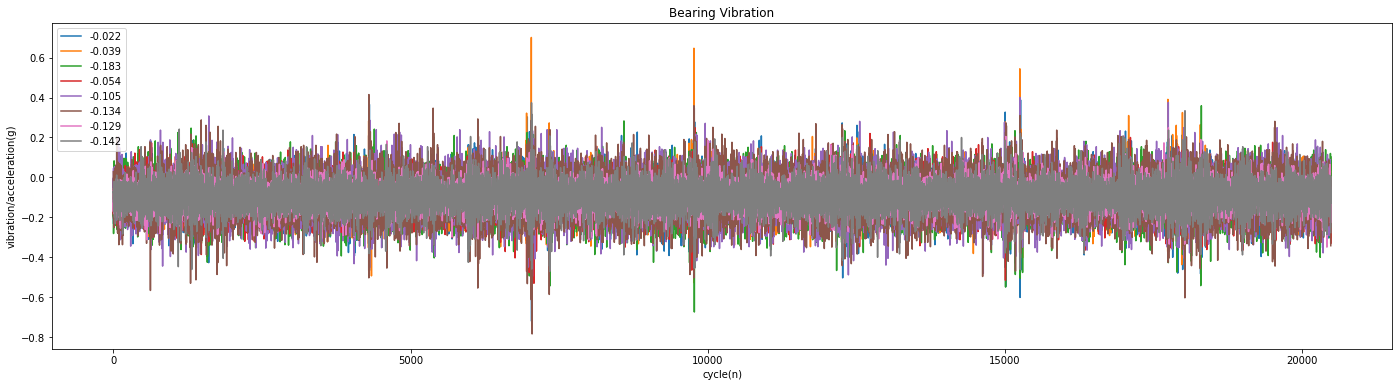

In [ ]:
dataset = pd.read_csv('/content/1st_test/2003.10.22.12.06.24', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()


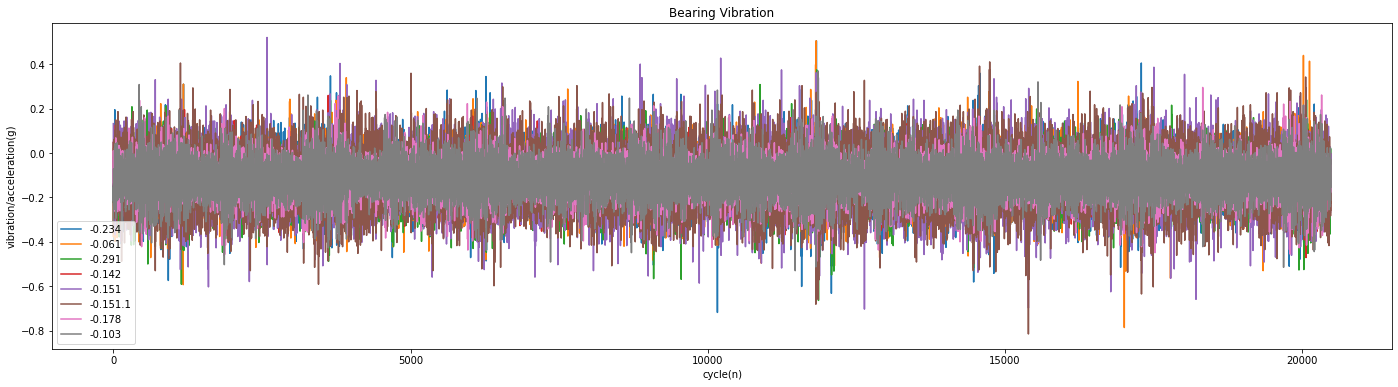

In [ ]:
dataset = pd.read_csv('/content/1st_test/2003.11.15.05.08.46', sep='\t')
ax = dataset.plot(figsize = (24,6), title= "Bearing Vibration" , legend = True)
ax.set(xlabel="cycle(n)", ylabel="vibration/acceleration(g)")
plt.show()

#Data Scoping and transforming datetime

In [ ]:
import datetime as dt

def timediff(x):
  first=dt.datetime(2003,10,22,13,59,13)
  timesince = (x - first).total_seconds()
  return  timesince/60
def timeleft(x):
  last=dt.datetime(2003,11,25,23,39,56)
  timesince = (last - x).total_seconds()
  return  abs(timesince/60)

In [ ]:
bearing_columns = data.columns[pd.Series(data.columns).str.startswith('b4_')]
columns = bearing_columns.tolist() + ['datetime']
data = data[columns]
data.head()

data['datetime']=data['datetime'].apply(timeleft)


TypeError: ignored

#Using SVR algorithm 
  - dataset dividing
  - data fitting 
  

In [ ]:
data=data.sort_values(by='datetime')
data.head()
train_df_svm =  data [int(0.8*n):]
train_df_svm.head()
test_df_svm =data[0:int(n*0.8)] 

# test_df_svm['datetime']=test_df_svm['datetime'].apply(timeleft)
# train_df_svm['datetime']=train_df_svm['datetime'].apply(timeleft)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
Y=train_df_svm[['datetime']].copy()
X=train_df_svm.copy()

del X['datetime']

Y_test=test_df_svm[['datetime']]
X_test=test_df_svm.copy()
del X_test['datetime']
sc_X=StandardScaler()
sc_Y=StandardScaler()
sc_X_test=StandardScaler()
# sc_Y_test=StandardScaler()




X = sc_X.fit_transform(X)

# Y = sc_Y.fit_transform(Y)
X_test=sc_X_test.fit_transform(X_test)
# Y_test=sc_Y_test.fit_transform(Y_test)




In [ ]:


regressor=SVR(kernel='sigmoid')

regressor.fit(X,Y)
svm_predict=regressor.predict(X_test)
# Y_test=Y_test.to_numpy()
regressor.score(X_test,Y_test)





/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-7.71497060867857

#Model Scoring 

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
print(r2_score(Y_test,svm_predict),
mean_absolute_error(Y_test,svm_predict),
mean_squared_error(Y_test,svm_predict)**0.5,len(svm_predict))








-7.71497060867857 25400.619803192847 26965.408556451323 1724


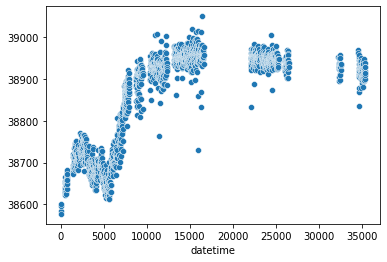

In [ ]:
bt =  sns.scatterplot(x=test_df_svm['datetime'],y=svm_predict)

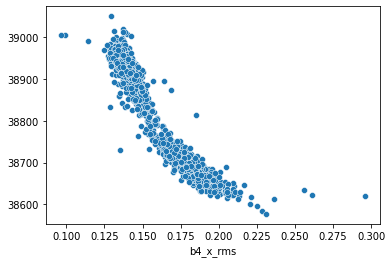

In [ ]:
bt =  sns.scatterplot(x=test_df_svm['b4_x_rms'],y=svm_predict)

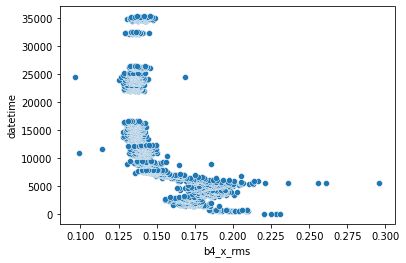

In [ ]:
bt =  sns.scatterplot(x=test_df_svm['b4_x_rms'],y=test_df_svm['datetime'])

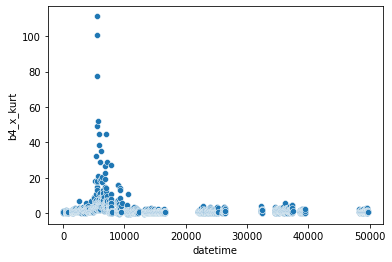

In [ ]:
at =  sns.scatterplot(y=data['b4_x_kurt'],x=data['datetime'])

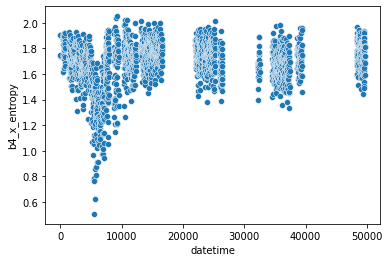

In [ ]:
at =  sns.scatterplot(y=data['b4_x_entropy'],x=data['datetime'])